# Extension Plan - Data Exploration

In this extension, I incorporate several additional datasets that provide insights into mortality rates due to respiratory diseases, asthma-related healthcare patterns (including both inpatient hospitalizations and emergency room visits), and the volume of respiratory-related medical procedures performed annually.

In this notebook, I perform an exploratory data analysis on the preprocessed health data to understand if/how the wildfires affect the health data.

In [35]:
#
#    IMPORTS
#

#    These are standard python modules. In case you do not have a python module, you should use `!pip install <module>`
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

First we load the smoke estimate data.

In [36]:
smoke_estimate_aqi_data = pd.read_csv("../Processed Data/smoke_estimate_with_year_aqi.csv", index_col=0)
smoke_estimate_aqi_data.rename(columns={"Fire_Year": "Year"}, inplace=True)
smoke_estimate_aqi_data

,Year,Smoke_Estimate,yearly_avg_aqi
0,1964,4.341713,5.386648
1,1965,4.000000,6.132075
2,1966,6.274285,4.641221
3,1967,7.693339,53.584158
4,1968,6.949404,63.722527
...,...,...,...
56,2020,64.000000,45.770657
57,2021,NaN,47.492489
58,2022,NaN,40.919786
59,2023,NaN,44.967453


### Dataset 1: CDC Wonder Mortality Data (Specifically due to respiratory diseases)

Here, I load the already [processed CDC Wonder data](../Processed%20Data/1999_2020_Mortality_Data.csv) and explore how the wildfires affect the mortality.

In [37]:
mortality_data = pd.read_csv("../Processed Data/1999_2020_Mortality_Data.csv")
mortality_data

,Year,Age Groups,Gender,Deaths
0,1999,0-24,Female,0
1,1999,0-24,Male,12
2,1999,25-64,Female,119
3,1999,25-64,Male,144
4,1999,65+,Female,1103
...,...,...,...,...
127,2020,0-24,Male,0
128,2020,25-64,Female,243
129,2020,25-64,Male,314
130,2020,65+,Female,1354


In [38]:
# Aggregated death values by year
mortality_aggregated_by_year = mortality_data.groupby('Year').agg({'Deaths': 'sum'}).reset_index()
mortality_aggregated_by_year.head()

,Year,Deaths
0,1999,2434
1,2000,2457
2,2001,2379
3,2002,2443
4,2003,2364


In [39]:
# Aggregated death values by year and age groups
mortality_aggregated_by_Age = mortality_data.groupby(['Year', 'Age Groups']).agg({'Deaths': 'sum'}).reset_index()
mortality_aggregated_by_Age.head()

,Year,Age Groups,Deaths
0,1999,0-24,12
1,1999,25-64,263
2,1999,65+,2159
3,2000,0-24,31
4,2000,25-64,296


In [40]:
# Aggregated death values by year and gender
mortality_aggregated_by_Gender = mortality_data.groupby(['Year', 'Gender']).agg({'Deaths': 'sum'}).reset_index()
mortality_aggregated_by_Gender.head()

,Year,Gender,Deaths
0,1999,Female,1222
1,1999,Male,1212
2,2000,Female,1250
3,2000,Male,1207
4,2001,Female,1219


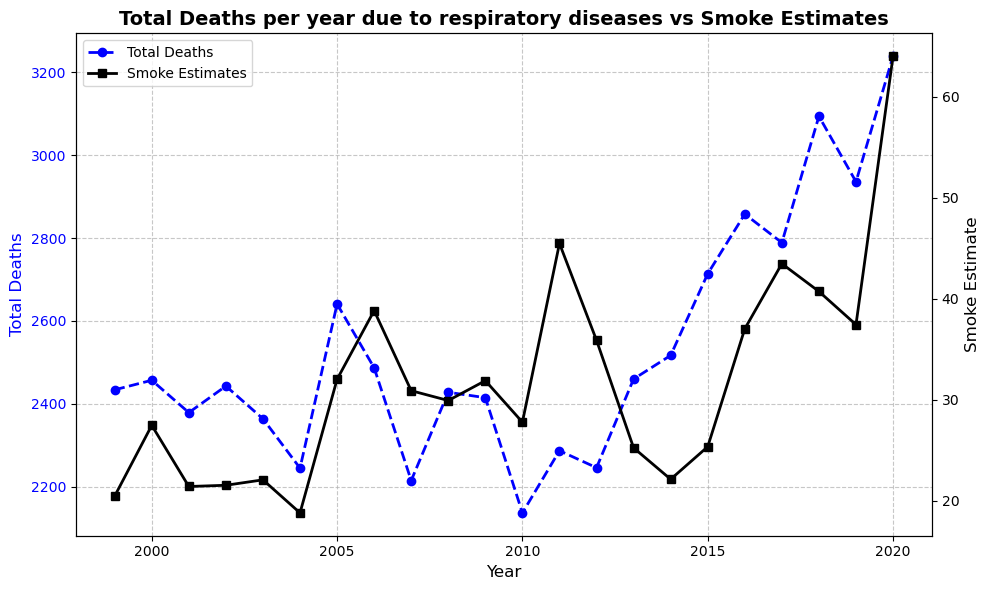

In [70]:
merged_mortality_by_year = pd.merge(mortality_aggregated_by_year, smoke_estimate_aqi_data, on='Year')

fig, ax1 = plt.subplots(figsize=(10, 6))
# Plot total deaths on the primary y-axis
ax1.plot(merged_mortality_by_year['Year'], merged_mortality_by_year['Deaths'], label='Total Deaths', color='blue', linestyle='--', linewidth=2, marker='o')
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Total Deaths', fontsize=12, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True, linestyle='--', alpha=0.7)

# Create a secondary y-axis for smoke estimates
ax2 = ax1.twinx()
ax2.plot(merged_mortality_by_year['Year'], merged_mortality_by_year['Smoke_Estimate'], label='Smoke Estimates', color='black', linewidth=2, marker='s')
ax2.set_ylabel('Smoke Estimate', fontsize=12, color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, fontsize=10)
plt.title('Total Deaths per year due to respiratory diseases vs Smoke Estimates', fontsize=14, fontweight='bold')
plt.tight_layout()

# Show the plot
plt.show()


In [42]:
# Calculate the correlation between 'Deaths' and 'Smoke_Estimate'
correlation = merged_mortality_by_year['Deaths'].corr(merged_mortality_by_year['Smoke_Estimate'])
print(f"Correlation between Deaths and Smoke Estimate: {correlation}")

Correlation between Deaths and Smoke Estimate: 0.624579197725384


In [71]:
# Save the chart as a PNG file
fig.savefig('../Output Files/Respiratory_Mortality_with_smoke_estimates.png', format='png', dpi=300)

From the chart and correlation scores above, we can see that deaths caused due to respiratory systems are correlated with wildfires, since as the smoke estimate increases, the deaths due to respiratory diseases tends to increase as well. We can also see that there is about 62.4% correlation between mortality and smoke estimate.

Now, that we have established a correlation between the smoke estimate and the total deaths, I decided to explore if a specific age group or gender is more strongly correlated to the smoke estimate and is affected by wildfires

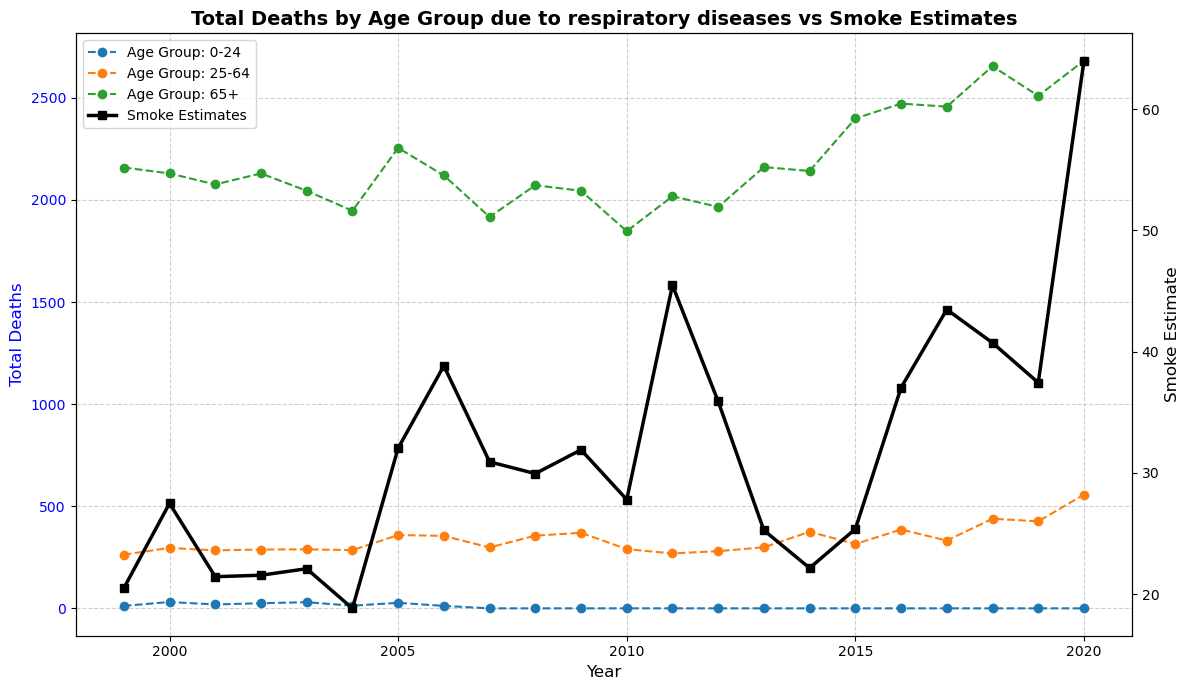

In [72]:
merged_mortality_by_age = pd.merge(mortality_aggregated_by_Age, smoke_estimate_aqi_data, on='Year')

fig, ax1 = plt.subplots(figsize=(12, 7))
# Plot deaths on the primary y-axis
for age_group in merged_mortality_by_age['Age Groups'].unique():
    age_group_data = merged_mortality_by_age[merged_mortality_by_age['Age Groups'] == age_group]
    ax1.plot(age_group_data['Year'], age_group_data['Deaths'], label=f"Age Group: {age_group}", linestyle='--', marker='o', linewidth=1.5)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Total Deaths', fontsize=12, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True, linestyle='--', alpha=0.6)

# Create a secondary y-axis for smoke estimates
ax2 = ax1.twinx()
smoke_estimates_mean = merged_mortality_by_age.groupby('Year')['Smoke_Estimate'].mean()
ax2.plot(smoke_estimates_mean.index, smoke_estimates_mean, 
         color='black', marker = 's', label="Smoke Estimates", linewidth=2.5)
ax2.set_ylabel('Smoke Estimate', fontsize=12, color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, fontsize=10)

plt.title("Total Deaths by Age Group due to respiratory diseases vs Smoke Estimates", fontsize=14, fontweight='bold')
plt.tight_layout()

# Show the plot
plt.show()


In [45]:
correlations_age = {}

# Loop through each age group and calculate the correlation with Smoke_Estimate
for age_group in mortality_aggregated_by_Age['Age Groups'].unique():
    age_group_data = merged_mortality_by_age[merged_mortality_by_age['Age Groups'] == age_group]
    correlation = age_group_data['Deaths'].corr(age_group_data['Smoke_Estimate'])
    correlations_age[age_group] = correlation

for age_group, corr_value in correlations_age.items():
    print(f"Correlation between total deaths and smoke estimate for age group {age_group}: {corr_value}")

Correlation between total deaths and smoke estimate for age group 0-24: -0.4290947423616012
Correlation between total deaths and smoke estimate for age group 25-64: 0.7046373379096695
Correlation between total deaths and smoke estimate for age group 65+: 0.5806408476844028


In [46]:
print(merged_mortality_by_age[merged_mortality_by_age["Age Groups"] == "0-24"])

    Year Age Groups  Deaths  Smoke_Estimate  yearly_avg_aqi
0   1999       0-24      12       20.482623       54.849141
3   2000       0-24      31       27.482062       51.371458
6   2001       0-24      19       21.431882       49.290578
9   2002       0-24      25       21.553465       53.063240
12  2003       0-24      30       22.090325       53.228136
15  2004       0-24      13       18.821474       45.149172
18  2005       0-24      27       32.035572       47.915494
21  2006       0-24      12       38.829661       47.896634
24  2007       0-24       0       30.907773       47.032512
27  2008       0-24       0       29.935974       47.256230
30  2009       0-24       0       31.900473       41.146936
33  2010       0-24       0       27.795122       41.402403
36  2011       0-24       0       45.475395       48.343569
39  2012       0-24       0       35.895075       46.572474
42  2013       0-24       0       25.257060       43.090722
45  2014       0-24       0       22.147

In [73]:
# Save the chart as a PNG file
fig.savefig('../Output Files/Respiratory_Mortality_by_age_with_smoke_estimates.png', format='png', dpi=300)

From the above chart as well as the correlation scores, we can see that mortality by age groups is strongly correlated with the smoke estimates. Additionally, we can see that those in the age groups 25 - 64 are the most correlated with the smoke. However, it's also important to note that mortality in the age group 65+ is much higher in general. We also see that there is limited data for age groups 0-24 so the results for that are not the most accurate.

Next, I decided to look into if a specific gender was more affected by the smoke

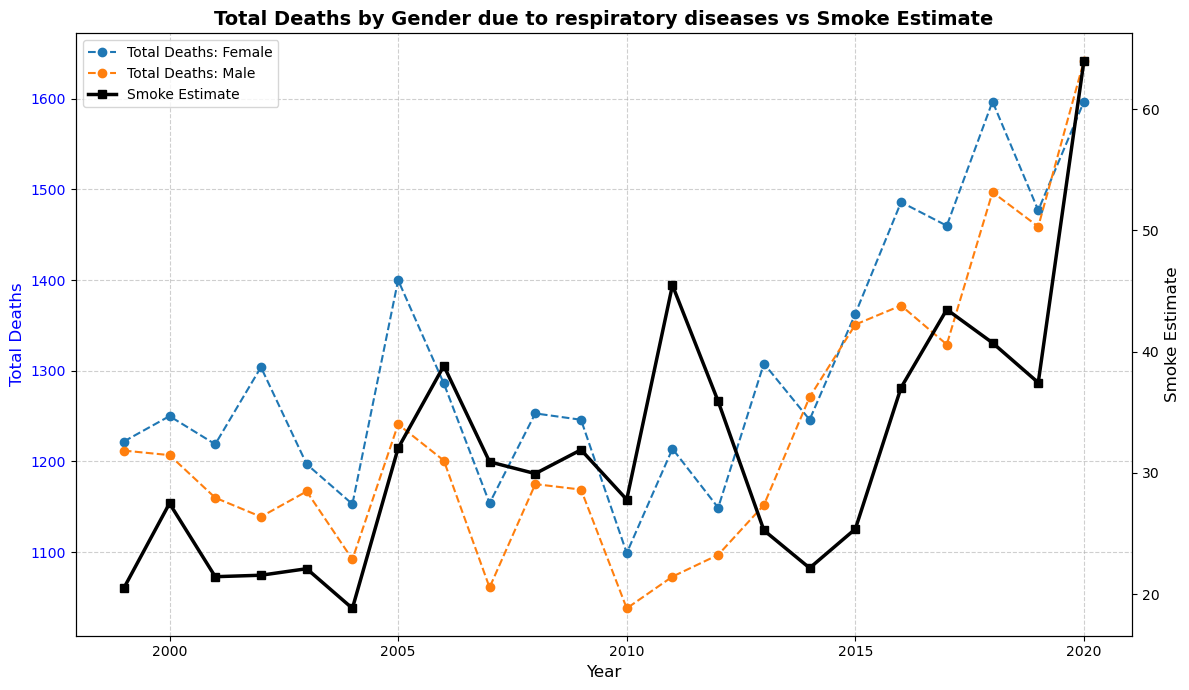

In [74]:
merged_mortality_by_gender = pd.merge(mortality_aggregated_by_Gender, smoke_estimate_aqi_data, on='Year')

fig, ax1 = plt.subplots(figsize=(12, 7))
# Plot total deaths (scaled) for each gender on the primary y-axis
for gender in merged_mortality_by_gender['Gender'].unique():
    gender_data = merged_mortality_by_gender[merged_mortality_by_gender['Gender'] == gender]
    ax1.plot(gender_data['Year'], gender_data['Deaths'], label=f"Total Deaths: {gender}", linestyle='--', marker='o', linewidth=1.5)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Total Deaths', fontsize=12, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True, linestyle='--', alpha=0.6)

# Create a secondary y-axis for smoke estimates
ax2 = ax1.twinx()
smoke_estimates_mean = merged_mortality_by_gender.groupby('Year')['Smoke_Estimate'].mean()
ax2.plot(smoke_estimates_mean.index, smoke_estimates_mean, color='black', marker = 's', label="Smoke Estimate", linewidth=2.5)
ax2.set_ylabel('Smoke Estimate', fontsize=12, color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, fontsize=10)
plt.title("Total Deaths by Gender due to respiratory diseases vs Smoke Estimate", fontsize=14, fontweight='bold')
plt.tight_layout()

# Show the plot
plt.show()


In [48]:
correlations_gender = {}

# Loop through the gender and calculate the correlation with Smoke_Estimate
for gender in mortality_aggregated_by_Gender['Gender'].unique():
    gender_data = merged_mortality_by_gender[merged_mortality_by_gender['Gender'] == gender]
    correlation = gender_data['Deaths'].corr(gender_data['Smoke_Estimate'])
    correlations_gender[gender] = correlation

for gender, corr_value in correlations_gender.items():
    print(f"Correlation between total deaths and smoke estimate for {gender}: {corr_value}")

Correlation between total deaths and smoke estimate for Female: 0.627287685329284
Correlation between total deaths and smoke estimate for Male: 0.5994134518706572


In [75]:
# Save the chart as a PNG file
fig.savefig('../Output Files/Respiratory_Mortality_by_gender_with_smoke_estimates.png', format='png', dpi=300)

From the above chart and the pearson correlation scores, we can see that females are slightly more affected than males by the smoke in Maricopa county.

### Dataset 2: ADHS Asthma-Related Inpatient Discharges and Emergency Visits Data

Here I take the already processed hospital inpatient discharges and emergency visits data and explore it's correlation with wildfires.

#### Emergency Visits Data

In [49]:
emergency_visit_data = pd.read_csv("../Processed Data/2003_2021_emergency_visits_data.csv")
emergency_visit_data.head()

,Year,Gender,Type of Record,"Asthma, All Mentions","Asthma, First Diagnosis"
0,2003,Female,Emergency Visits,8591,3358
1,2003,Male,Emergency Visits,6804,3336
2,2004,Female,Emergency Visits,18366,6273
3,2004,Male,Emergency Visits,14039,6245
4,2005,Female,Emergency Visits,23984,7346


In [50]:
# Aggregated emergency visits value by year for Asthma, All Mentions
all_mentions_EV_aggregated_by_year = emergency_visit_data.groupby('Year').agg({'Asthma, All Mentions': 'sum'}).reset_index()
all_mentions_EV_aggregated_by_year.head()

,Year,"Asthma, All Mentions"
0,2003,15395
1,2004,32405
2,2005,42054
3,2006,44403
4,2007,45697


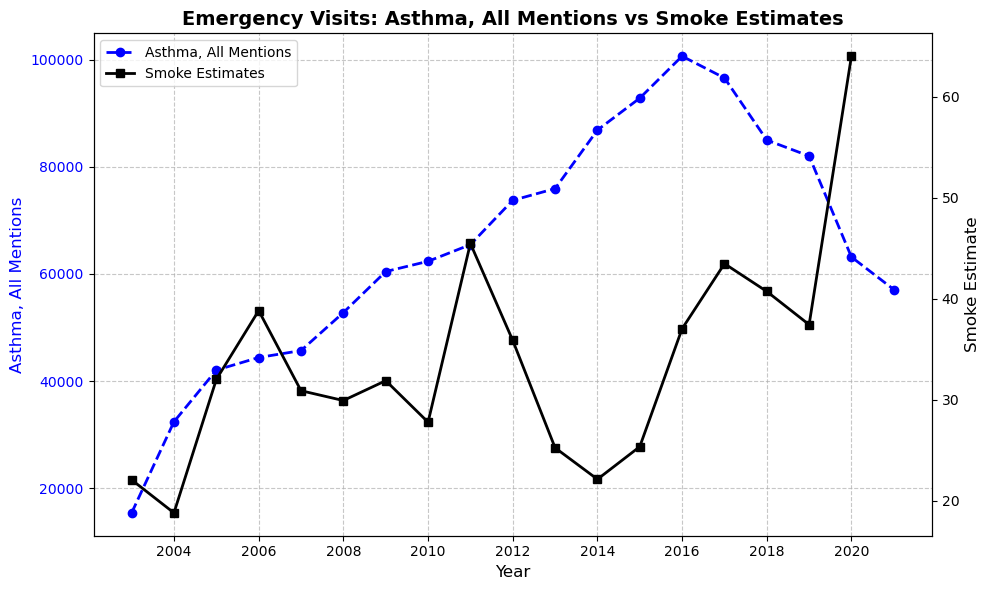

In [76]:
merged_all_mentions_EV_by_year = pd.merge(all_mentions_EV_aggregated_by_year, smoke_estimate_aqi_data, on='Year')
merged_all_mentions_EV_by_year['Year'] = pd.to_datetime(merged_all_mentions_EV_by_year['Year'], format='%Y')

fig, ax1 = plt.subplots(figsize=(10, 6))
# Plot scaled Asthma, All mentions on the primary y-axis
ax1.plot(merged_all_mentions_EV_by_year['Year'], merged_all_mentions_EV_by_year['Asthma, All Mentions'], label='Asthma, All Mentions', color='blue', linestyle='--', linewidth=2, marker='o')
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Asthma, All Mentions', fontsize=12, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True, linestyle='--', alpha=0.7)

# Create a secondary y-axis for smoke estimates
ax2 = ax1.twinx()
ax2.plot(merged_all_mentions_EV_by_year['Year'], merged_all_mentions_EV_by_year['Smoke_Estimate'], label='Smoke Estimates', color='black', linewidth=2, marker='s')
ax2.set_ylabel('Smoke Estimate', fontsize=12, color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, fontsize=10)
plt.title('Emergency Visits: Asthma, All Mentions vs Smoke Estimates', fontsize=14, fontweight='bold')
plt.tight_layout()

# Show the plot
plt.show()


In [52]:
# Calculate the correlation between Asthma, all mentions and 'Smoke_Estimate'
correlation = merged_all_mentions_EV_by_year['Asthma, All Mentions'].corr(merged_all_mentions_EV_by_year['Smoke_Estimate'])
print(f"Correlation between emergency visits, Asthma all mentions and Smoke Estimate: {correlation}")

Correlation between emergency visits, Asthma all mentions and Smoke Estimate: 0.2658065954404748


In [77]:
# Save the chart as a PNG file
fig.savefig('../Output Files/Asthma_All_mentions_emergency_visits_with_smoke_estimates.png', format='png', dpi=300)

From above, we can see that the correlation between smoke and all mentions of Asthma is not that high. Now, we take a look at whether the first diagnosis as Asthma has a better correlation

In [53]:
# Aggregated emergency visits value by year for Asthma, First Diagnosis
first_diagnosis_EV_aggregated_by_year = emergency_visit_data.groupby('Year').agg({'Asthma, First Diagnosis': 'sum'}).reset_index()
first_diagnosis_EV_aggregated_by_year.head()

,Year,"Asthma, First Diagnosis"
0,2003,6694
1,2004,12518
2,2005,14559
3,2006,13472
4,2007,14646


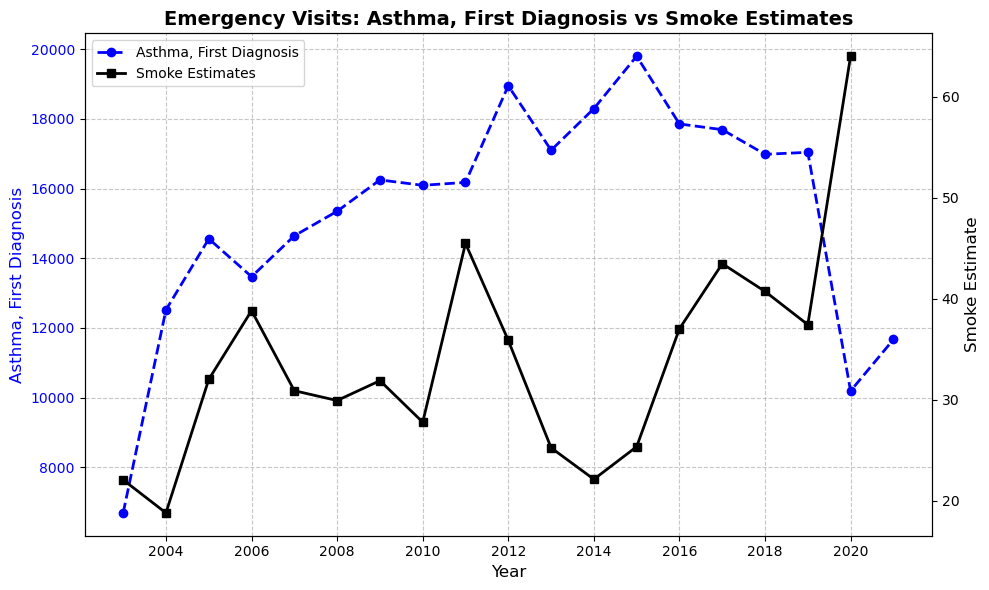

In [78]:
merged_first_diagnosis_EV_by_year = pd.merge(first_diagnosis_EV_aggregated_by_year, smoke_estimate_aqi_data, on='Year')
merged_first_diagnosis_EV_by_year['Year'] = pd.to_datetime(merged_first_diagnosis_EV_by_year['Year'], format='%Y')

fig, ax1 = plt.subplots(figsize=(10, 6))
# Plot scaled Asthma, First Diagnosis on the primary y-axis
ax1.plot(merged_first_diagnosis_EV_by_year['Year'], merged_first_diagnosis_EV_by_year['Asthma, First Diagnosis'], label='Asthma, First Diagnosis', color='blue', linestyle='--', linewidth=2, marker='o')
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Asthma, First Diagnosis', fontsize=12, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True, linestyle='--', alpha=0.7)

# Create a secondary y-axis for smoke estimates
ax2 = ax1.twinx()
ax2.plot(merged_first_diagnosis_EV_by_year['Year'], merged_first_diagnosis_EV_by_year['Smoke_Estimate'], label='Smoke Estimates', color='black', linewidth=2, marker='s')
ax2.set_ylabel('Smoke Estimate', fontsize=12, color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, fontsize=10, loc='upper left')
plt.title('Emergency Visits: Asthma, First Diagnosis vs Smoke Estimates', fontsize=14, fontweight='bold')
plt.tight_layout()

# Show the plot
plt.show()


In [55]:
# Calculate the correlation between 'Asthma, first diagnosis' and 'Smoke_Estimate'
correlation = merged_first_diagnosis_EV_by_year['Asthma, First Diagnosis'].corr(merged_first_diagnosis_EV_by_year['Smoke_Estimate'])
print(f"Correlation between emergency visits, Asthma first diagnosis and Smoke Estimate:  {correlation}")

Correlation between emergency visits, Asthma first diagnosis and Smoke Estimate:  -0.07764293338887898


In [79]:
# Save the chart as a PNG file
fig.savefig('../Output Files/Asthma_first_diagnosis_emergency_visits_with_smoke_estimates.png', format='png', dpi=300)

We see that the correlation between 'Asthma, first diagnosis' and 'Smoke_Estimate' is even weaker. 
Overall, we can conclude that emergency room visits for asthma related causes are not as strongly correlated with the smoke estimates. This is okay since emergency room visits mean severe symptoms and this might be limited to patients who are also suffering from other conditions. 

#### Inpatient Discharges Data

In [56]:
inpatient_discharges_data = pd.read_csv("../Processed Data/2003_2021_inpatient_discharge_data.csv")
inpatient_discharges_data.head()

,Year,Gender,Type of Record,"Asthma, All Mentions","Asthma, First Diagnosis"
0,2003,Female,Inpatient Discharge,6540,1168
1,2003,Male,Inpatient Discharge,3517,1066
2,2004,Female,Inpatient Discharge,13729,2318
3,2004,Male,Inpatient Discharge,7321,1836
4,2005,Female,Inpatient Discharge,14963,2444


In [57]:
# Aggregated inpatient discharges data by year for Asthma, All Mentions
inpatient_discharges_AM_aggregated_by_year = inpatient_discharges_data.groupby('Year').agg({'Asthma, All Mentions': 'sum'}).reset_index()
inpatient_discharges_AM_aggregated_by_year.head()

,Year,"Asthma, All Mentions"
0,2003,10057
1,2004,21050
2,2005,23037
3,2006,23588
4,2007,24349


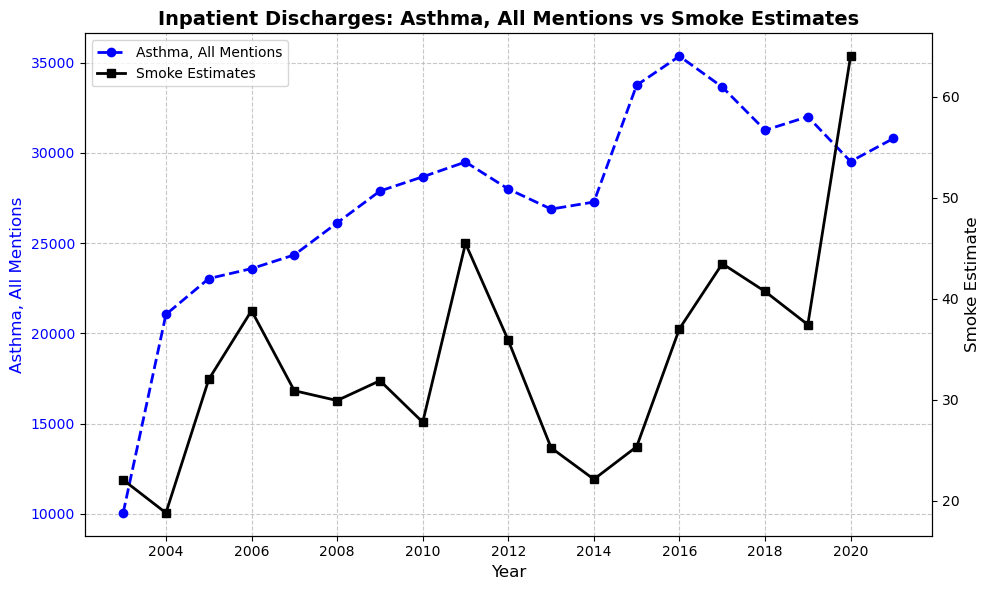

In [80]:
merged_all_mentions_ID_by_year = pd.merge(inpatient_discharges_AM_aggregated_by_year, smoke_estimate_aqi_data, on='Year')
merged_all_mentions_ID_by_year['Year'] = pd.to_datetime(merged_all_mentions_ID_by_year['Year'], format='%Y')

fig, ax1 = plt.subplots(figsize=(10, 6))
# Plot scaled Asthma, All Mentions on the primary y-axis
ax1.plot(merged_all_mentions_ID_by_year['Year'], merged_all_mentions_ID_by_year['Asthma, All Mentions'], label='Asthma, All Mentions', color='blue', linestyle='--', linewidth=2, marker='o')
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Asthma, All Mentions', fontsize=12, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True, linestyle='--', alpha=0.7)

# Create a secondary y-axis for smoke estimates
ax2 = ax1.twinx()
ax2.plot(merged_all_mentions_ID_by_year['Year'], merged_all_mentions_ID_by_year['Smoke_Estimate'], label='Smoke Estimates', color='black', linewidth=2, marker='s')
ax2.set_ylabel('Smoke Estimate', fontsize=12, color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, fontsize=10, loc='upper left')
plt.title('Inpatient Discharges: Asthma, All Mentions vs Smoke Estimates', fontsize=14, fontweight='bold')
plt.tight_layout()

# Show the plot
plt.show()


In [59]:
# Calculate the correlation between 'Asthma, All Mentions' for Inpatient Discharges and 'Smoke_Estimate'
correlation = merged_all_mentions_ID_by_year['Asthma, All Mentions'].corr(merged_all_mentions_ID_by_year['Smoke_Estimate'])
print(f"Correlation between inpatient discharges, Asthma all mentions and Smoke Estimate: {correlation}")

Correlation between inpatient discharges, Asthma all mentions and Smoke Estimate: 0.43755101385252615


In [81]:
# Save the chart as a PNG file
fig.savefig('../Output Files/Asthma_All_mentions_inpatient_discharges_with_smoke_estimates.png', format='png', dpi=300)

From the above correlation and figure we can see that there is a higher correlation between inpatient discharges, for Asthma all mentions and the smoke estimate, especially in comparison to the emergency visits data. This makes sense since the emergency visits data is usually limited to serere cases, whereas inpatient discharges also include elective surgeries.

In [60]:
# Aggregated inpatient discharges data by year for Asthma, First Diagnosis
inpatient_discharges_FD_aggregated_by_year = inpatient_discharges_data.groupby('Year').agg({'Asthma, First Diagnosis': 'sum'}).reset_index()
inpatient_discharges_FD_aggregated_by_year.head()

,Year,"Asthma, First Diagnosis"
0,2003,2234
1,2004,4154
2,2005,4347
3,2006,4080
4,2007,4273


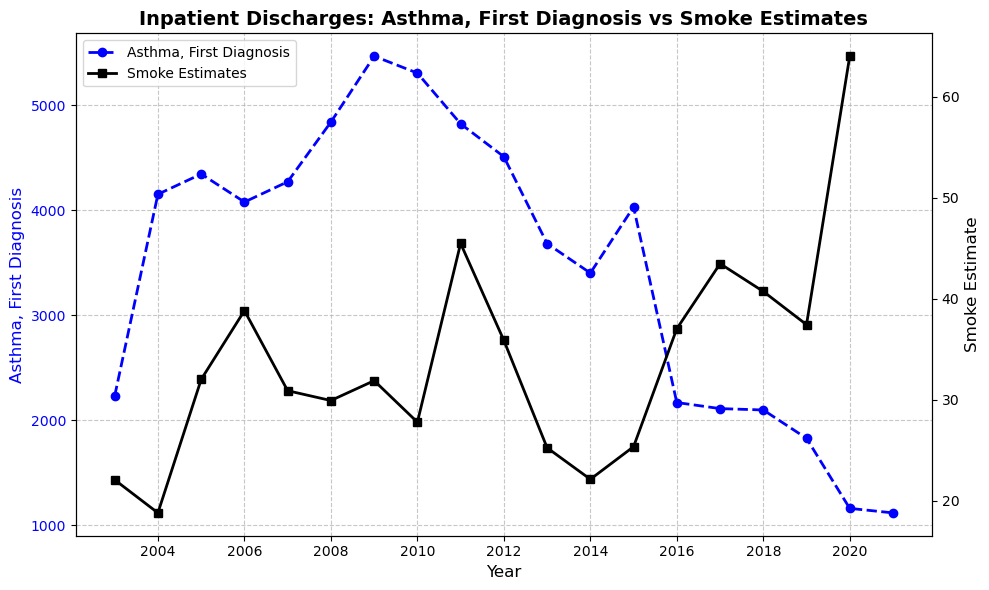

In [82]:
merged_first_diagnosis_ID_by_year = pd.merge(inpatient_discharges_FD_aggregated_by_year, smoke_estimate_aqi_data, on='Year')
merged_first_diagnosis_ID_by_year['Year'] = pd.to_datetime(merged_first_diagnosis_ID_by_year['Year'], format='%Y')

fig, ax1 = plt.subplots(figsize=(10, 6))
# Plot scaled Asthma, First Diagnosis on the primary y-axis
ax1.plot(merged_first_diagnosis_ID_by_year['Year'], merged_first_diagnosis_ID_by_year['Asthma, First Diagnosis'], label='Asthma, First Diagnosis', color='blue', linestyle='--', linewidth=2, marker='o')
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Asthma, First Diagnosis', fontsize=12, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True, linestyle='--', alpha=0.7)

# Create a secondary y-axis for smoke estimates
ax2 = ax1.twinx()
ax2.plot(merged_first_diagnosis_ID_by_year['Year'], merged_first_diagnosis_ID_by_year['Smoke_Estimate'], label='Smoke Estimates', color='black', linewidth=2, marker='s')
ax2.set_ylabel('Smoke Estimate', fontsize=12, color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=10)
plt.title('Inpatient Discharges: Asthma, First Diagnosis vs Smoke Estimates', fontsize=14, fontweight='bold')
plt.tight_layout()

# Show the plot
plt.show()


In [62]:
# Calculate the correlation between 'Asthma, First Diagnosis' and 'Smoke_Estimate'
correlation = merged_first_diagnosis_ID_by_year['Asthma, First Diagnosis'].corr(merged_first_diagnosis_ID_by_year['Smoke_Estimate'])
print(f"Correlation between inpatient discharges, Asthma first diagnosis and Smoke Estimate: {correlation}")

Correlation between inpatient discharges, Asthma first diagnosis and Smoke Estimate: -0.4462426752180413


In [83]:
# Save the chart as a PNG file
fig.savefig('../Output Files/Asthma_first_diagnosis_inpatient_discharges_with_smoke_estimates.png', format='png', dpi=300)

What is interesting in this result is that this shows a strong negative correlation, which is the opposite of what inpatient discharges, Asthma All Diagnosis showed. This could make sense as asthma on it's own isn't really that severe for inpatient discharges however when it is combined with other illnesses it could cause lead to more severe issues.

Overall, we can conclude that Asthma is moderately related with the smoke estimates.

### Dataset 3: ADHS Medical Procedures Data

Here I take the already processed procedures data and explore the effects of wildfires on it, if any.

In [63]:
respiratory_operations_data = pd.read_csv("../Processed Data/2000_2020_respiratory_system_operations.csv")
respiratory_operations_data

,Year,Total
0,2000,7964
1,2001,8953
2,2002,9507
3,2003,10061
4,2004,10951
5,2005,11804
6,2006,12709
7,2007,13075
8,2008,13985
9,2009,14571


First, I analyse the respiratory operations data to see if the number of respiratory operations rises or changes with the smoke estimates

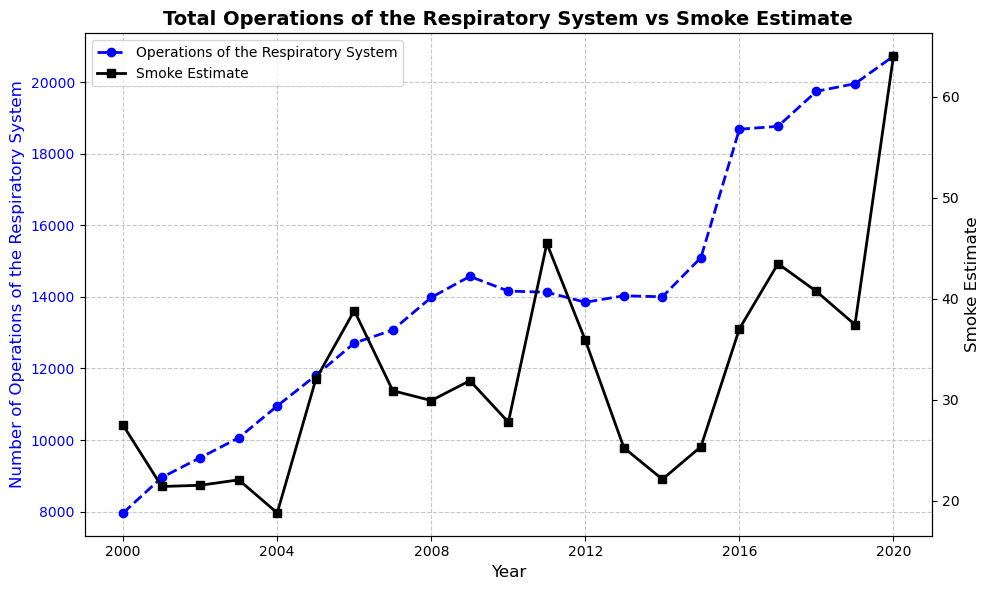

In [90]:
merged_respiratory_operations_data = pd.merge(respiratory_operations_data, smoke_estimate_aqi_data, on='Year', how='inner')

# Convert 'Year' to datetime
merged_respiratory_operations_data['Year'] = pd.to_datetime(merged_respiratory_operations_data['Year'], format='%Y')

fig, ax1 = plt.subplots(figsize=(10, 6))
# Plot the scaled number of procedures on the primary y-axis
ax1.plot(merged_respiratory_operations_data['Year'],  merged_respiratory_operations_data['Total'], marker='o', linestyle='--', color='blue', label='Operations of the Respiratory System', linewidth=2)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Number of Operations of the Respiratory System', fontsize=12, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True, linestyle='--', alpha=0.7)

# Create a secondary y-axis for smoke estimates
ax2 = ax1.twinx()
ax2.plot(merged_respiratory_operations_data['Year'], merged_respiratory_operations_data['Smoke_Estimate'], marker='s', color='black', label='Smoke Estimate', linewidth=2)
ax2.set_ylabel('Smoke Estimate', fontsize=12, color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=10)
plt.title('Total Operations of the Respiratory System vs Smoke Estimate', fontsize=14, fontweight='bold')
plt.tight_layout()

# Show the plot
plt.show()


In [65]:
correlation =  merged_respiratory_operations_data['Total'].corr(merged_respiratory_operations_data['Smoke_Estimate'])
print(f"Correlation between Operations of the Respiratory System and smoke estimate: {correlation}")

Correlation between Operations of the Respiratory System and smoke estimate: 0.722109533457049


In [91]:
# Save the chart as a PNG file
fig.savefig('../Output Files/Operations_of_respiratory_system_with_smoke_estimates.png', format='png', dpi=300)

From above we can see a clear strong positive correlation between the number of respiratory operations and smoke estimate suggesting that with increase in the number of wildfires (that leads to higher smoke), people require more respiratory operations, meaning that wildfire is impacting respiratory health.

Now, I analyze if a similar trend is found in respiratory therapy data.

In [66]:
respiratory_therapy_data = pd.read_csv("../Processed Data/2000_2015_respiratory_therapy.csv")
respiratory_therapy_data

,Year,Total
0,2000,6788
1,2001,7220
2,2002,7801
3,2003,10682
4,2004,9819
5,2005,11796
6,2006,12290
7,2007,12970
8,2008,14531
9,2009,16002


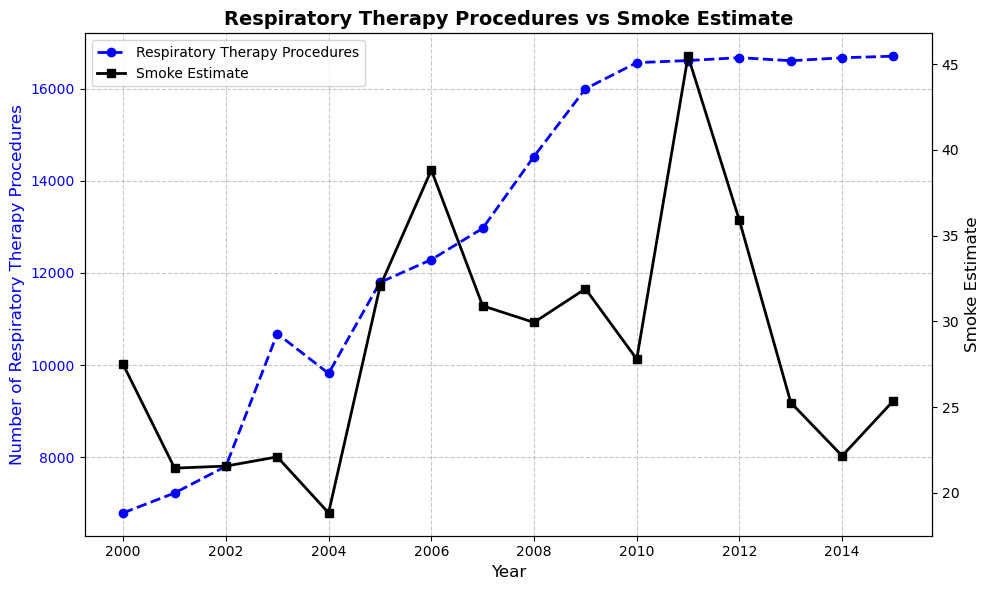

In [88]:
merged_respiratory_therapy_data = pd.merge(respiratory_therapy_data, smoke_estimate_aqi_data, on='Year', how='inner')

# Convert 'Year' to datetime
merged_respiratory_therapy_data['Year'] = pd.to_datetime(merged_respiratory_therapy_data['Year'], format='%Y')

# Create the plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the scaled number of procedures on the primary y-axis
ax1.plot(merged_respiratory_therapy_data['Year'], merged_respiratory_therapy_data['Total'], marker='o', linestyle='--', color='blue', 
    label='Respiratory Therapy Procedures', linewidth=2)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Number of Respiratory Therapy Procedures', fontsize=12, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True, linestyle='--', alpha=0.7)

# Create a secondary y-axis for smoke estimates
ax2 = ax1.twinx()
ax2.plot(merged_respiratory_therapy_data['Year'], merged_respiratory_therapy_data['Smoke_Estimate'], marker='s', color='black', label='Smoke Estimate', linewidth=2)
ax2.set_ylabel('Smoke Estimate', fontsize=12, color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=10)
plt.title('Respiratory Therapy Procedures vs Smoke Estimate', fontsize=14, fontweight='bold')
plt.tight_layout()

# Show the plot
plt.show()


In [68]:
correlation = merged_respiratory_therapy_data['Total'].corr(merged_respiratory_therapy_data['Smoke_Estimate'])
print(f"Correlation between the number of Respiratory Therapies and smoke estimate: {correlation}")

Correlation between the number of Respiratory Therapies and smoke estimate: 0.42109672545517757


In [89]:
# Save the chart as a PNG file
fig.savefig('../Output Files/Respiratory_therapy_with_smoke_estimates.png', format='png', dpi=300)

From above, we can see that the number of Respiratory Therapies is also positively correlated with the smoke estimate.
Based on the above two procedures we can confirm that a rise in smoke estimates is associated with a rise in the number of respiratory related procedures, further indicating that wildfires do affect health

Now that all correlation are established, I decided to visualize it using a correlation matrix

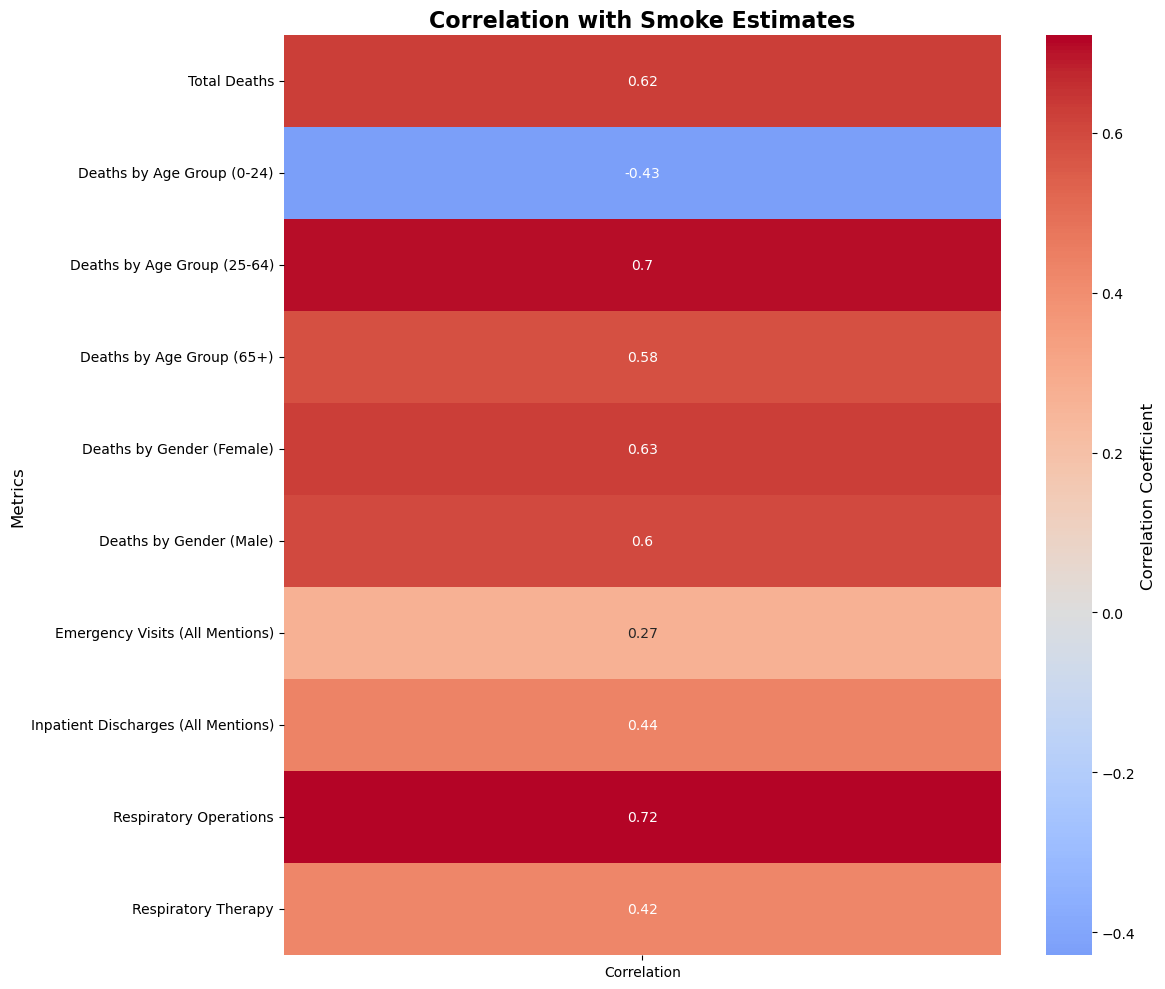

In [92]:
# Create a dictionary with all the correlations
correlation_dict = {
    'Total Deaths': merged_mortality_by_year['Deaths'].corr(merged_mortality_by_year['Smoke_Estimate']),
    'Deaths by Age Group': correlations_age,
    'Deaths by Gender': correlations_gender,
    'Emergency Visits (All Mentions)': merged_all_mentions_EV_by_year['Asthma, All Mentions'].corr(merged_all_mentions_EV_by_year['Smoke_Estimate']),
    'Inpatient Discharges (All Mentions)': merged_all_mentions_ID_by_year['Asthma, All Mentions'].corr(merged_all_mentions_ID_by_year['Smoke_Estimate']),
    'Respiratory Operations': merged_respiratory_operations_data['Total'].corr(merged_respiratory_operations_data['Smoke_Estimate']),
    'Respiratory Therapy': merged_respiratory_therapy_data['Total'].corr(merged_respiratory_therapy_data['Smoke_Estimate'])
}

# Flatten the dictionary for age groups and gender
flattened_dict = {}
for key, value in correlation_dict.items():
    if isinstance(value, dict):
        for sub_key, sub_value in value.items():
            flattened_dict[f'{key} ({sub_key})'] = sub_value
    else:
        flattened_dict[key] = value

# Convert the dictionary to a DataFrame
correlation_df = pd.DataFrame(list(flattened_dict.items()), columns=['Metric', 'Correlation'])
correlation_df.set_index('Metric', inplace=True)

# Add the smoke estimate to the chart
fig, ax1 = plt.subplots(figsize=(12, 10))

# Plot the correlations
sns.heatmap(correlation_df, annot=True, cmap='coolwarm', center=0, ax=ax1, cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation with Smoke Estimates', fontsize=16, fontweight='bold')
plt.ylabel('Metrics', fontsize=12)
plt.yticks(fontsize=10)
colorbar = ax1.collections[0].colorbar
colorbar.set_label('Correlation Coefficient', fontsize=12)
colorbar.ax.tick_params(labelsize=10)
plt.tight_layout()
plt.show()

In [93]:
# Save the chart as a PNG file
fig.savefig('../Output Files/correlation_with_smoke_estimates.png', format='png', dpi=300)

Based on the analysis done in this file we can say that there is a strong positive correlation between wildfires (based on smoke estimates) and the mortality due to respiratory diseases and the medical procedures data (Operations of the respiratory system and respiratory therapy). We also see that there is limited correlation between Asthma related emergency visist and inpatient discharges in the Maricopa county. 